In [1]:
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import pandas as pd
import spacy

from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from os import listdir
from os.path import isfile, join
from rouge_score import rouge_scorer
from rouge import Rouge 

rouge = Rouge()
nlp = spacy.load("en_core_web_sm")

In [48]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')
scores['rouge1']#[1]

Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765)

Import files

In [12]:
val_preproc_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\2021val_annual_reports_prepr-20220901T133401Z-001\2021val_annual_reports_prepr"
name_of_files = [f for f in listdir(val_preproc_dir) 
             if isfile(join(val_preproc_dir, f))]
list_of_files = []
for file_name in name_of_files:
    list_of_files.append(open(val_preproc_dir + "\\" + file_name, "r").read())

Preprocess data

In [3]:
def delete_nums(txt_splited):
    res_finish = []
    for text in tqdm(txt_splited):
        res_txt = []
        for paragraph in text:
            res_par = ''
            for i in re.split('\.| ',paragraph):
                if i.isalpha():
                    res_par += i.lower() + ' '
            res_txt.append(res_par)
        res_finish.append(res_txt)
    return res_finish

In [4]:
txt_splited = [file_txt.split('\n') for file_txt in list_of_files]
txt_str_div_par = delete_nums(txt_splited)

  0%|          | 0/363 [00:00<?, ?it/s]

In [5]:
def make_vocab(txt_str_div_par):
    txt_str = txt_str_div_par.copy()
    for i, txt in enumerate(txt_str_div_par):
        txt_str[i] = ''.join(txt)

    vocab_list = []
    for i, txt in enumerate(txt_str):
        vocab = list(re.split(' \n| ', txt))

        if '' in set(vocab):
            vocab.remove("")
        vocab_list.append(list(set(vocab)))
    return vocab_list, txt_str

In [7]:
def list_of_words_max_len(txt_str):
    list_of_words = [txt.split(' ') for txt in txt_str]
    for i in range(len(list_of_words)):
        list_of_words[i] = [w for w in list_of_words[i] if w]

    len_words = [len(v) for v in list_of_words]
    max_len_words = max(len_words)
    return list_of_words, len_words, max_len_words

make functions for calculating results in sparse matrix for time and memory optimization

In [8]:
def sparse_triangle_max(max_len_words, sig=25):    
    S = sp.dok_array((max_len_words + 2 * sig, max_len_words + 2 * sig), dtype=np.float32)
    res_f = [(1 - np.abs(i - sig) / sig) for i in range(1, sig * 2)]
    for i in tqdm(range(sig, sig + max_len_words), total=max_len_words):
        S[i, i-sig+1:i+sig] = res_f
    return S

In [9]:
def sparse_triangle_crop(S, size, sig=25):
    return S[sig:sig+size, sig:sig+size]

In [10]:
def sparse_vocab(text, vocab):    
    S = sp.dok_array((len(vocab), len(text)), dtype=np.float32)
    v_to_i = {v:i for i, v in enumerate(vocab)}
    for j, w in enumerate(text):
        S[v_to_i[w], j] = 1
    
    return S

calculate matix

In [11]:
def matix_txt(S, text, vocab):
    len_txt = len(text)

    f_res = sparse_triangle_crop(S, len_txt) # l x l
    c_vocab = sparse_vocab(text, vocab) # w x l

    num = c_vocab.tocsr() @ f_res.tocsc() # w x l @ l x l = w x l
    denum = (c_vocab.tocsr() @ f_res.tocsc()).tocsc().sum(axis=0) # w x l @ l x l = w x l sum axis0 = 1xl
    
    denum = sp.csc_matrix(1 / denum)

    return num * denum

calculate propogation matix

In [12]:
def calculate_save_npz(list_of_words, S, vocab_list, name_of_files, dir_to_save):
    for i in tqdm(range(len(list_of_words))):
        matix_item = matix_txt(S, list_of_words[i], vocab_list[i])    
        sp.save_npz(dir_to_save + name_of_files[i][:-4], matix_item)

download calculated matix and sum scores of the words per paragraph

In [13]:
def calculate_sum_of_art(txt_str_div_art, sum_arr_word, v_to_i, dict_weight, weights=[1, 2]):
    article_weight, len_per_art = [], []
    heavy_words = []
    for article in txt_str_div_art:
        split = [j for j in article.split(' ') if j]
        len_art = len(split)
        if len_art != 0:
            par_split = 0
            word_heavy = 0
            for word in split:
                w = weights[1] if word in dict_weight else weights[0]
                word_heavy += w // max(weights)
                par_split += sum_arr_word[v_to_i[word]] * w
            heavy_words.append(word_heavy / len_art)
            article_weight.append(float(par_split) / len_art)
            len_per_art.append(len_art)
        else:
            article_weight.append(0)
            len_per_art.append(0)
            heavy_words.append(0)
            
    return pd.DataFrame(list(zip(article_weight, len_per_art, heavy_words)), columns=['sum', 'len', 'wght'])

In [ ]:
calculate_sum_of_art(txt_str_div_art, sum_arr_word, v_to_i, [], weights=[1, 1])

In [11]:
def top_art(res):
    sorted_res = res.sort_values(by=['sum'], ascending=False)
    sorted_res['index'] = sorted_res.index

    i, len_txt = 0, 0
    num_art = []
    while i < len(sorted_res) and len_txt < 1000:
        len_txt += sorted_res.iloc(0)[i]['len']
        num_art.append(int(sorted_res.iloc(0)[i]['index'])) 
        i += 1
    num_art.sort()
    return num_art, int(len_txt)

In [23]:
def download_npz(name_of_files, vocab_list, txt_str_div_par, dir_to_upload, weight):
    art_sum = []
    for i_t, text_name in tqdm(enumerate(name_of_files), total=len(name_of_files)):

        #calculate best articles in txt based on matrix
        sum_arr_word = sp.load_npz(dir_to_upload + text_name[:-4] + ".npz").sum(axis=1)
        v_to_i = {v:i for i, v in enumerate(vocab_list[i_t])}
        art_sum.append(calculate_sum_of_art(txt_str_div_par[i_t], sum_arr_word, v_to_i, [], weight))
    return art_sum

In [13]:
def read_files(val_dir):
    name_of_files = [f for f in listdir(val_dir) 
                 if isfile(join(val_dir, f))]
    list_of_files = []
    for file_name in name_of_files:        
        list_of_files.append(open(val_dir + "\\" + file_name, "r", encoding='utf-8').read())
    return name_of_files, list_of_files

In [6]:
def calc_rouge_mean(name_of_files, list_of_files, name_of_files_gold=name_of_files_gold, list_of_files_gold=list_of_files_gold, suf=4, cut=True):
    j = 0
    df_scores = pd.DataFrame(columns = ["rouge-1, r", "rouge-1, p", "rouge-1, f", 
                                        "rouge-2, r", "rouge-2, p", "rouge-2, f", 
                                        "rouge-l, r", "rouge-l, p", "rouge-l, f"])

    for i in tqdm(range(len(name_of_files)), total=len(name_of_files)):
        scores = []

        while j < len(name_of_files_gold) and name_of_files_gold[j][:-6] != name_of_files[i][:-suf]:
            j += 1
        while j < len(name_of_files_gold) and name_of_files_gold[j][:-6] == name_of_files[i][:-suf]:
            if cut == True:
                list_of_files[i] = ' '.join(list_of_files[i].split(' ')[:1000])            
            scores.append(rouge.get_scores(list_of_files[i], list_of_files_gold[j])[0])
            j += 1
#         print(scores)
        if scores != []:
            res_arr = np.zeros((len(scores), 9))
            for i in range(len(scores)):
                lst_i = list(scores[i].items())
                
                res_arr[i] = [list(lst_i[0][1].items())[0][1],
                              list(lst_i[0][1].items())[1][1],
                              list(lst_i[0][1].items())[2][1], 
                              list(lst_i[1][1].items())[0][1],
                              list(lst_i[1][1].items())[1][1],
                              list(lst_i[1][1].items())[2][1],
                              list(lst_i[2][1].items())[0][1],
                              list(lst_i[2][1].items())[1][1],
                              list(lst_i[2][1].items())[2][1]]
#                 print(res_arr[i])
            df_scores.loc[len(df_scores)] = res_arr.mean(axis=0)
        
    return df_scores

In [7]:
vocab_list, txt_str = make_vocab(txt_str_div_par)

In [9]:
list_of_words, len_words, max_len_words = list_of_words_max_len(txt_str)

In [ ]:
S = sparse_triangle_max(max_len_words)

In [20]:
calculate_save_npz(list_of_words, S, vocab_list, name_of_files, dir_to_save=r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\PLM matrix\\")

  0%|          | 0/363 [00:00<?, ?it/s]

In [26]:
art_sum = (download_npz(name_of_files, vocab_list, txt_str_div_par, dir_to_upload=r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\PLM matrix\\", weight=[1, 1]))

  0%|          | 0/363 [00:00<?, ?it/s]

In [10]:
def download_npz_word(name_of_files, dir_to_upload):
    sum_arr_word, v_to_i = [], []
    for i_t, text_name in tqdm(enumerate(name_of_files), total=len(name_of_files)):
        sum_arr_word.append(sp.load_npz(dir_to_upload + text_name[:-4] + ".npz").sum(axis=1))
        v_to_i.append({v:i for i, v in enumerate(vocab_list[i_t])})
#         art_sum.append(calculate_sum_of_art(txt_str_div_par[i_t], sum_arr_word, v_to_i, [], weight))
    return sum_arr_word, v_to_i

In [11]:
word_plm, v_to_i = download_npz_word(name_of_files, dir_to_upload=r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\PLM matrix\\")

  0%|          | 0/363 [00:00<?, ?it/s]

In [12]:
def plm_list_by_words(txt_str, v_to_i, word_plm):
    plm_list = []
    for i_t, text in tqdm(enumerate(txt_str), total=len(txt_str)):
        new_m = []
        for word in text.split():
            new_m.append(word_plm[i_t][v_to_i[i_t][word]][0, 0])
        plm_list.append(new_m)
    return plm_list

In [13]:
plm_list = plm_list_by_words(txt_str, v_to_i, word_plm)

  0%|          | 0/363 [00:00<?, ?it/s]

In [14]:
gold_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\fns2020_dataset_clean\validation\gold_summaries"
name_of_files_gold = [f for f in listdir(gold_dir) 
             if isfile(join(gold_dir, f))]
list_of_files_gold = []
for file_name in name_of_files_gold:
    list_of_files_gold.append(open(gold_dir + "\\" + file_name, "r", encoding='utf-8').read())

In [15]:
def preproc(txt_splited):
    res_finish, res_glue = [], []
    for text in tqdm(txt_splited):
        res_txt = []
        for paragraph in text:
            res_par = ''
            for i in re.split('\.| ',paragraph):
                if i.isalpha():
                    res_par += i.lower() + ' '
            res_txt.append(res_par)
        res_glue.append(''.join(res_txt))
        res_finish.append(res_txt)
    return res_finish, res_glue

In [16]:
txt_splited_gold = [file_txt.split('\n') for file_txt in list_of_files_gold]
txt_str_div_par_gold, txt_str_gold = preproc(txt_splited_gold)

  0%|          | 0/1250 [00:00<?, ?it/s]

In [17]:
from collections import defaultdict

In [18]:
val_gold = defaultdict(list)
for i, v in enumerate(name_of_files_gold):
    val_gold[v[:-6]].append(i)
# val_gold

In [49]:
def calc_rouge(txt, txt_gold):
    lst_i = scorer.score(txt, txt_gold)
                
    res_arr = np.array([
                      lst_i['rouge1'][0],
                      lst_i['rouge1'][1],
                      lst_i['rouge1'][2],
                      lst_i['rouge2'][0],
                      lst_i['rouge2'][1],            
                      lst_i['rouge2'][2],
                      lst_i['rougeL'][0],
                      lst_i['rougeL'][1],            
                      lst_i['rougeL'][2]])
    return res_arr

In [70]:
def split_window(text, plm_text, name_file, window=2000, step=1000):
    text_split = text.split()
    val_gold_txt = val_gold[name_file]
    rouge_list, plm_list = [], []
    for i in range(window, len(text_split), step):
        rouge_mean = 0
        for i_w in val_gold_txt:
            rouge_mean += calc_rouge(' '.join(text_split[i - window:i]), txt_str_gold[i_w])
        rouge_mean = rouge_mean / len(val_gold_txt)
        rouge_list.append(rouge_mean)
        plm_list.append(sum(plm_text[i - window:i]) / window)
    return rouge_list, plm_list

In [74]:
for i in tqdm(range(len(txt_str))):
    rouge, plm = split_window(txt_str[i], plm_list[i], name_of_files[i][:-4])    
    df_plm = pd.DataFrame(plm, columns=['PLM'])
    df_rouge = pd.DataFrame(rouge, columns=['rouge1, p', 'rouge1, r', 'rouge1, f',
                                          'rouge2, p', 'rouge2, r', 'rouge2, f',
                                          'rougeL, p', 'rougeL, r', 'rougeL, f'])
    pd.concat([df_rouge, df_plm], axis=1).to_csv(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\window res\\' + name_of_files[i][:-4])    

  0%|          | 0/363 [00:00<?, ?it/s]

In [3]:
tmp_pd = pd.read_csv(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\window res\31620')

In [9]:
def count_corr(dir_file):
    tmp_pd = pd.read_csv(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\window res\\' + dir_file)
    list_corr = []
    for i in range(len(tmp_pd.columns) - 1):
        list_corr.append(tmp_pd[tmp_pd.columns[i]].corr(tmp_pd['PLM']))
    return np.array(list_corr)

In [13]:
result_arr = np.zeros((len(name_of_files), 10))
for i, file in enumerate(name_of_files):
    result_arr[i] = count_corr(file[:-4])

In [25]:
res_pd_corr = pd.concat([pd.DataFrame(result_arr), pd.DataFrame(np.mean(result_arr, axis=0), columns=['mean']).T])

In [27]:
res_pd_corr = res_pd_corr.rename(columns={0:'posision', 
                 1:'rouge1, p', 2:'rouge1, r', 3:'rouge1, f',
                 4:'rouge2, p', 5:'rouge2, r', 6:'rouge2, f',
                 7:'rougeL, p', 8:'rougeL, r', 9:'rougeL, f'})

,posision,"rouge1, p","rouge1, r","rouge1, f","rouge2, p","rouge2, r","rouge2, f","rougeL, p","rougeL, r","rougeL, f"
0,-0.058245,0.404122,0.249870,0.272862,0.364778,0.218013,0.242593,0.274335,0.163927,0.184348
1,0.297874,-0.094433,-0.149403,-0.146226,-0.084381,-0.105480,-0.104279,-0.050137,-0.092536,-0.081782
2,-0.218776,0.117063,0.171678,0.168217,0.210090,0.260744,0.254393,0.077065,0.121835,0.116789
3,0.337930,-0.475399,-0.412067,-0.433481,-0.410098,-0.329355,-0.361609,-0.332046,-0.217169,-0.255217
4,-0.565934,0.457319,0.513286,0.486862,0.233573,0.389503,0.323710,0.220533,0.395830,0.327878


In [29]:
res_pd_corr.to_csv(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\result_corr_windows.csv')

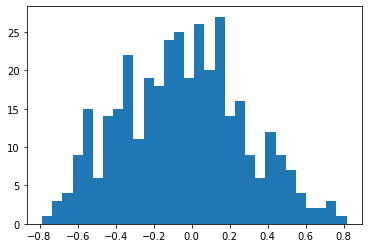

In [38]:
plt.hist(res_pd_corr.iloc(0)[:-1].iloc(1)[0], bins=30);

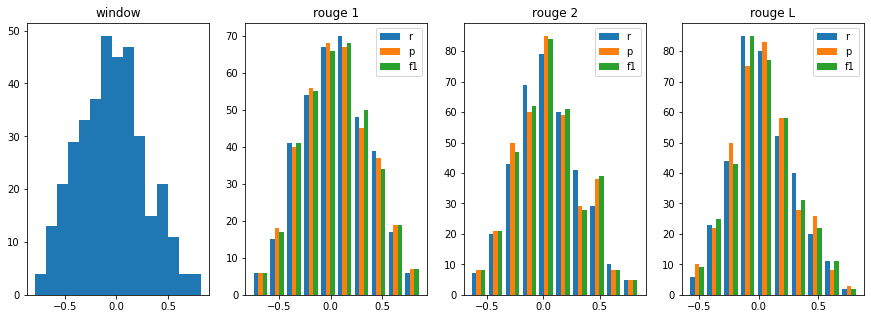

In [42]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].hist(res_pd_corr.iloc(0)[:-1].iloc(1)[0], bins=15);
# axs[0].legend()
axs[0].set_title('window')
axs[1].hist(res_pd_corr.iloc(0)[:-1].iloc(1)[1:4], label=['r', 'p', 'f1']);
axs[1].legend()
axs[1].set_title('rouge 1')
axs[2].hist(res_pd_corr.iloc(0)[:-1].iloc(1)[4:7], label=['r', 'p', 'f1']);
axs[2].legend()
axs[2].set_title('rouge 2')
axs[3].hist(res_pd_corr.iloc(0)[:-1].iloc(1)[7:], label=['r', 'p', 'f1']);
axs[3].legend()
axs[3].set_title('rouge L');